# Train models based on balanced dataset
## Read the dataset
The here used dataset is a version with selected features based on the EDA and feature selection. See EDA_Feature_Selection notebook for the reasoning of choices made.

In [12]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [13]:
df = pd.read_csv('parkinson_feature_selection.csv')
df = df.iloc[: , 1:]
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(Abs),HNR,RPDE,D2,DFA,spread2,status
0,119.992,157.302,74.997,0.00007,21.033,0.414783,2.301442,0.815285,0.266482,1
1,122.400,148.650,113.819,0.00008,19.085,0.458359,2.486855,0.819521,0.335590,1
2,116.682,131.111,111.555,0.00009,20.651,0.429895,2.342259,0.825288,0.311173,1
3,116.676,137.871,111.366,0.00009,20.644,0.434969,2.405554,0.819235,0.334147,1
4,116.014,141.781,110.655,0.00011,19.649,0.417356,2.332180,0.823484,0.234513,1


## Prepare the data

In [16]:
# store target variable y
y = df.status.values

# create feature matrix
X = np.array(df.loc[ : , df.columns != 'status']) # these are the features (matrix)
X.shape

(195, 9)

In [17]:
# Normalize the data
def normalize(X):
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    return X

X = normalize(X)

## Conduct group balancing

There are two options to balance the groups:
- undersampling: reduce samples in the majority class 
- oversampling: increase number of samples in the minority class 
Undersampling may discard a lot of information while oversampling might be a costly task to conduct. Undersampling could be conducted using TOMEK technique, which picks quite close data points from opposite classes (pairs) and discards the points from each pair which belongs to the majority class. Here this would lead to loss of a lot of data so oversampling is prefered. Here conducted is the SMOTE technique, which measures the distances between the minority class and creates synthetic observations inbetween adjacent observations from the minority class [https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/].

In [18]:
def make_barplot(y):
    ar_unique, counts = np.unique(y, return_counts = True)
    plt.bar(ar_unique, counts)
    plt.show()
    print(counts)

Original dataset shape (195,)


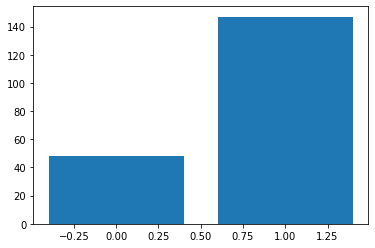

[ 48 147]
Resample dataset shape (294,)


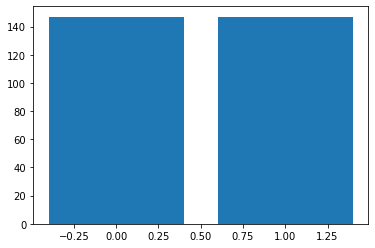

[147 147]


In [19]:
# build smote model
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

# print the original data shape
print('Original dataset shape', y.shape)
make_barplot(y)

# print resampled data shape
print('Resample dataset shape', y_smote.shape)
make_barplot(y_smote)

# Built models

In [20]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = .3, random_state=42)

In [22]:
# logistic regression
# train the model
logreg = LogisticRegression()
history = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy score:', accuracy_score(y_pred, y_test))

print('Confusion matrix:', confusion_matrix(y_test,y_pred))

Accuracy score: 0.797752808988764
Confusion matrix: [[35  4]
 [14 36]]


In [23]:
#xgboost classifier
xgb_model = XGBClassifier().fit(X_train, y_train)

# predict
xgb_y_predict = xgb_model.predict(X_test)

# accuracy score
print('Accuracy score:', accuracy_score(xgb_y_predict, y_test))

print('Confusion matrix:', confusion_matrix(y_test,xgb_y_predict))

[17:01:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score: 0.9213483146067416
Confusion matrix: [[39  0]
 [ 7 43]]


C:\Users\chiar\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
